In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms

%matplotlib inline

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [3]:
def unpickle(file, b=True):
    import pickle
    with open(file, 'rb') as fo:
        if b:
            return pickle.load(fo, encoding='bytes')
        return pickle.load(fo)

classes_dict = unpickle('./data/cifar-100-python/meta', False)
classes = classes_dict['fine_label_names']

torch.Size([4, 3, 32, 32])


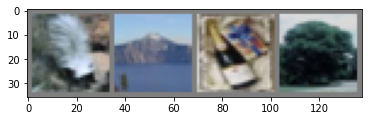

skunk mountain bottle oak_tree


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
imshow(torchvision.utils.make_grid(images))
classes = classes_dict['fine_label_names']
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
accuracies = dict()

In [6]:
def train_model(net, max_epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    history_train_loss, history_test_loss = [], []
    epoch = 1
    eps = 1e-4
    while epoch <= max_epochs and (len(history_train_loss) < 2 or history_train_loss[-2] - history_train_loss[-1] > eps):
        running_train_loss = 0.0
        running_test_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            print(inputs.shape)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        history_train_loss.append(running_train_loss / len(trainloader))
        
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                images, labels = data
                outputs = net(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
        history_test_loss.append(running_test_loss / len(testloader))
        
#        print(f'[{epoch}] train loss: {history_train_loss[-1]}, test loss: {history_test_loss[-1]}')
        epoch += 1

    print('Finished Training')
    return (history_train_loss, history_test_loss, optimizer.state_dict())

In [7]:
def test_model(net, cnt_param):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network with {cnt_param} parameters: {round(100 * correct / total, 2)} %')
    return correct / total

In [8]:
def get_model_info(net, max_epochs, name):
    net_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(net_params)

    history_train_loss, history_test_loss, optimizer_dict = train_model(net, max_epochs)
    accuracy = test_model(net, net_params)
    accuracies[net_params] = accuracy

    fig = plt.figure(figsize=(8, 6))
    epochs_number = len(history_train_loss)
    x = np.arange(1, epochs_number + 1)
    plt.title(f"Model with {name} paremeters training", fontsize=16)
    plt.plot(x, history_train_loss, label="train")
    plt.plot(x, history_test_loss, label="test")
    plt.legend(fontsize=14, shadow=0.2, loc="upper right")
    plt.xlabel("Epoch number", fontsize=14)
    plt.ylabel("Cross Entropy Loss", fontsize=14)
    
    plt.grid()
    plt.show()
    fig.savefig(f"model_{name}_training.jpg", bbox_inches='tight')
    
#    PATH = f'model_checkpoints/model_{name}.pt'
#    torch.save({'epoch': epochs_number,
#               'model_state_dict': net.state_dict(),
#               'optimizer_state_dict': optimizer_dict,
#               'loss': history_train_loss[-1],
#            }, PATH)
    
    return (net_params, accuracy, history_train_loss, history_test_loss)

In [9]:
class Net_2K(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.bn = nn.BatchNorm2d(5)
        self.fc1 = nn.Linear(20, 100)

    def forward(self, x):
        x = self.pool(x)
        x = self.bn(self.pool(F.relu(self.conv1(x))))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

net_2K = Net_2K()
net_2K_params, accuracy_2K, history_train_loss_2K, history_test_loss_2K = get_model_info(net_2K, 20, "2K")
accuracies[net_2K_params] = accuracy_2K

2250
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 3

/home/katsam/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
t

torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])


KeyboardInterrupt: 

4850
Finished Training
Accuracy of the network with 4850 parameters: 19.78 %


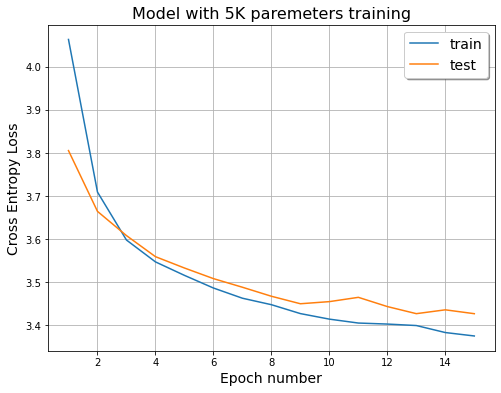

In [10]:
class Net_5K(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 10, 3)
        self.bn2 = nn.BatchNorm2d(10)
        self.pool = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(40, 100)

    def forward(self, x):
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

net_5K = Net_5K()
net_5K_params, accuracy_5K, history_train_loss_5K, history_test_loss_5K = get_model_info(net_5K, 15, "5K")
accuracies[net_5K_params] = accuracy_5K

10161
Finished Training
Accuracy of the network with 10161 parameters: 21.27 %


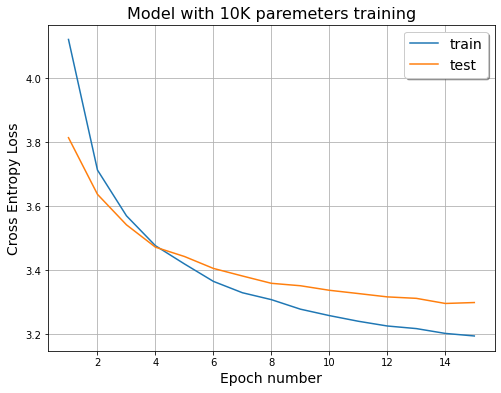

In [11]:
class Net_10K(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 10, 3)
        self.bn2 = nn.BatchNorm2d(10)
        self.conv3 = nn.Conv2d(10, 12, 3)
        self.bn3 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(48, 55)
        self.fc2 = nn.Linear(55, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net_10K = Net_10K()
net_10K_params, accuracy_10K, history_train_loss_10K, history_test_loss_10K = get_model_info(net_10K, 15, "10K")
accuracies[net_10K_params] = accuracy_10K

49525
Finished Training
Accuracy of the network with 49525 parameters: 29.89 %


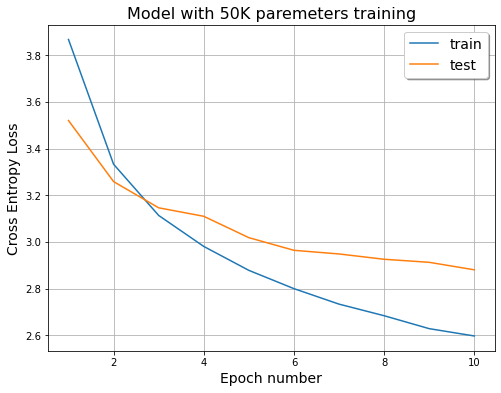

In [12]:
class Net_50K(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128, 189)
        self.fc2 = nn.Linear(189, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net_50K = Net_50K()
net_50K_params, accuracy_50K, history_train_loss_50K, history_test_loss_50K = get_model_info(net_50K, 10, "50K")
accuracies[net_50K_params] = accuracy_50K

99949
Finished Training
Accuracy of the network with 99949 parameters: 34.85 %


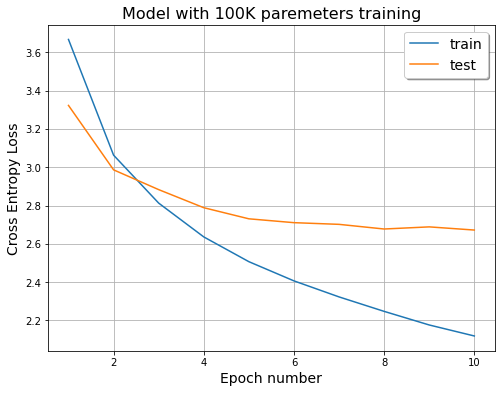

In [13]:
class Net_100K(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 213)
        self.fc2 = nn.Linear(213, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net_100K = Net_100K()
net_100K_params, accuracy_100K, history_train_loss_100K, history_test_loss_100K = get_model_info(net_100K, 10, "100K")
accuracies[net_100K_params] = accuracy_100K

503396
Finished Training
Accuracy of the network with 503396 parameters: 42.53 %


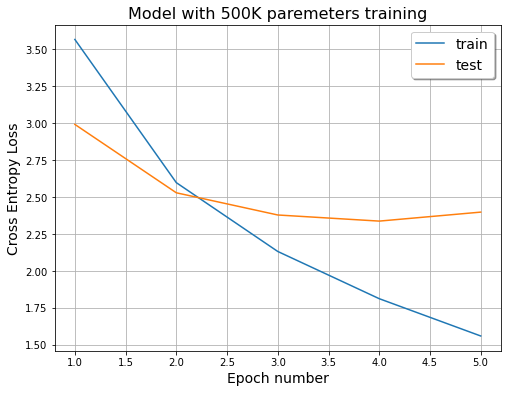

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 64, pool=True) 
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) 
                
        self.classifier = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Flatten(),
                                        nn.Linear(4096, num_classes))
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.classifier(out)
        return out
    
net_500K = ResNet(3, 100)
net_500K_params, accuracy_500K, history_train_loss_500K, history_test_loss_500K = get_model_info(net_500K, 5, "500K")
accuracies[net_500K_params] = accuracy_500K

1001362
Finished Training
Accuracy of the network with 1001362 parameters: 42.6 %


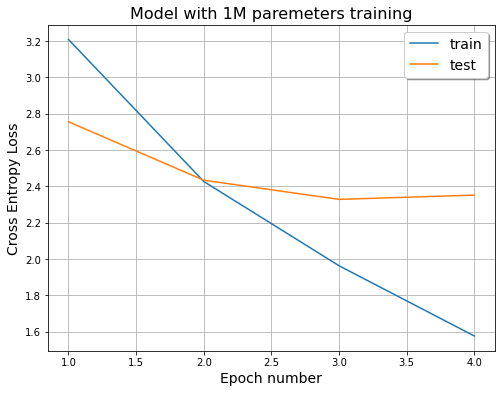

In [15]:
class Net_1M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4096, 150)
        self.fc2 = nn.Linear(150, 100)

    def forward(self, x):
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        x = self.bn3(self.pool(F.relu(self.conv3(x))))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net_1M = Net_1M()
net_1M_params, accuracy_1M, history_train_loss_1M, history_test_loss_1M = get_model_info(net_1M, 4, "1M")
accuracies[net_1M_params] = accuracy_1M

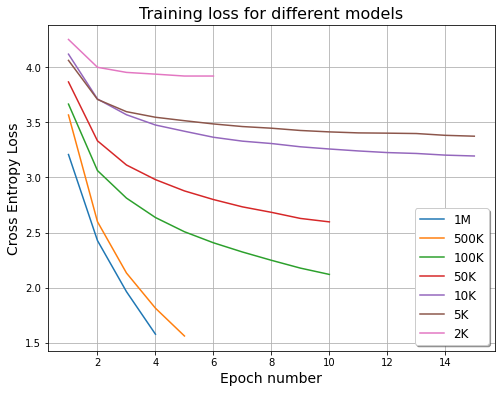

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.title("Training loss for different models", fontsize=16)
plt.plot(np.arange(1, len(history_train_loss_1M)+1),   history_train_loss_1M, label="1M")
plt.plot(np.arange(1, len(history_train_loss_500K)+1), history_train_loss_500K, label="500K")
plt.plot(np.arange(1, len(history_train_loss_100K)+1), history_train_loss_100K, label="100K")
plt.plot(np.arange(1, len(history_train_loss_50K)+1),  history_train_loss_50K, label="50K")
plt.plot(np.arange(1, len(history_train_loss_10K)+1),  history_train_loss_10K, label="10K")
plt.plot(np.arange(1, len(history_train_loss_5K)+1),   history_train_loss_5K, label="5K")
plt.plot(np.arange(1, len(history_train_loss_2K)+1),   history_train_loss_2K, label="2K")
plt.grid(True)
plt.legend(fontsize=12, shadow=0.2)
plt.xlabel("Epoch number", fontsize=14)
plt.ylabel("Cross Entropy Loss", fontsize=14)
plt.show()
fig.savefig("training_losses.jpg", bbox_inches='tight')

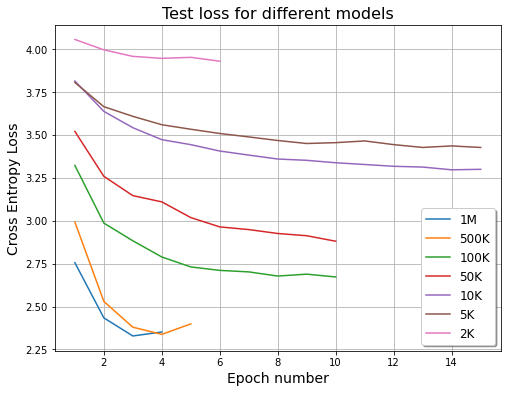

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.title("Test loss for different models", fontsize=16)
plt.plot(np.arange(1, len(history_test_loss_1M)+1),   history_test_loss_1M, label="1M")
plt.plot(np.arange(1, len(history_test_loss_500K)+1), history_test_loss_500K, label="500K")
plt.plot(np.arange(1, len(history_test_loss_100K)+1), history_test_loss_100K, label="100K")
plt.plot(np.arange(1, len(history_test_loss_50K)+1),  history_test_loss_50K, label="50K")
plt.plot(np.arange(1, len(history_test_loss_10K)+1),  history_test_loss_10K, label="10K")
plt.plot(np.arange(1, len(history_test_loss_5K)+1),   history_test_loss_5K, label="5K")
plt.plot(np.arange(1, len(history_test_loss_2K)+1),   history_test_loss_2K, label="2K")
plt.grid(True)
plt.legend(fontsize=12, shadow=0.2)
plt.xlabel("Epoch number", fontsize=14)
plt.ylabel("Cross Entropy Loss", fontsize=14)
plt.show()
fig.savefig("test_losses.jpg", bbox_inches='tight')

In [18]:
accuracies

{2250: 0.1059,
 4850: 0.1978,
 10161: 0.2127,
 49525: 0.2989,
 99949: 0.3485,
 503396: 0.4253,
 1001362: 0.426}

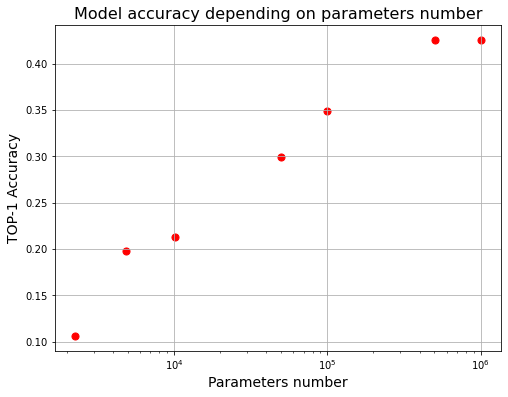

In [19]:
fig = plt.figure(figsize=(8, 6))
plt.title("Model accuracy depending on parameters number", fontsize=16)
plt.scatter(accuracies.keys(), accuracies.values(), s=50, color="red")
plt.xlabel("Parameters number", fontsize=14)
plt.ylabel("TOP-1 Accuracy", fontsize=14)
plt.xscale("log")
#plt.xticks([1000, 5000, 10000, 50000, 100000])
plt.grid()
plt.show()
fig.savefig("model_accuracies_new.jpg", bbox_inches='tight')